# Unique Passes

This is inspired by @FC_rstats

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import os, sys
# We have to append the parent folder because we are running this from inside notebook
sys.path.append("../")
import pystatsbomb as sb
from pystatsbomb.plotting import plotpitch, plotpitch_bokeh
from pystatsbomb.plotting import pass_rose, getArrow
import datetime
import pandas as pd
import pickle
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.models import Arrow, OpenHead, Label
from bokeh.io import show, output_notebook
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

In [3]:
output_notebook()

Loading BokehJS ...

# Table of Contents

1. [Download Data](#Download-Statsbomb-World-Cup-Data)
2. [Build Passing DataFrame](#Build-Passing-DataFrame)
3. [Setting Up Nearest Neighbors](#Set-Up-Nearest-Neighbors)
4. [Plotting Unique Passes](#Plotting-Unique-Passes)
5. [Most Unique Passers and Passes](#Most-Unique-Passers-and-Passes)
6. [Unique Passes in Final Third](#Unique-Passes-In-Final-Third)
7. [Example: Ivan Rakitic](#Rakitic-Plot)


# Download Statsbomb World Cup Data

In [4]:
c = sb.Client(local_source_dir=None)
c.get_competitions()
# Check to see what competitions are returned
print([{comp["competition_name"]: comp["competition_id"]}  for comp in c.competitions])

[{"FA Women's Super League": 37}, {'FIFA World Cup': 43}, {'NWSL': 49}]


In [5]:
comp_id = 43  # FIFA World Cup
match_ids = None  # Get all data
deep_lineup_parse = True

In [6]:
c.get_all_sb_data(
    comp_id=comp_id,
    match_ids=match_ids,
    deep_lineup_parse=deep_lineup_parse,
    toPandas=True)

Beginning Deep Lineup Parse


In [7]:
df_matches = c.df_matches.set_index('match_id')
df_lineups = c.df_lineups
df_events = c.df_events

df_deep_lineups = c.df_deep_lineup
df_play_time = c.df_play_time
df_positions = c.df_positions

# Build Passing DataFrame

In [8]:
pass_values = [
    'index', "match_id", 'duration', 'id', 'period','minute','second', 
    'type_name', 'player_name',
    'position_name', "team_name",
    'possession_team_name', 'possession', 'possession_team_id',
    'related_events', 'under_pressure', 'location', 
    # Pass details
    'pass_aerial_won', 'pass_angle', 'pass_assisted_shot_id', 'pass_backheel', 
    'pass_body_part_id', 'pass_body_part_name', 'pass_cross', 'pass_deflected', 
    'pass_end_location', 'pass_goal_assist', 'pass_height_id', 'pass_height_name', 
    'pass_length', 'pass_outcome_id', 'pass_outcome_name', 'pass_recipient_id', 
    'pass_recipient_name', 'pass_shot_assist', 'pass_switch', 'pass_through_ball',
    'pass_type_id', 'pass_type_name']

df_passes = df_events.loc[(df_events['type_name'].isin(['Pass'])) &
                          (~df_events["pass_type_name"].isin(["Goal Kick", "Corner", "Throw-in", "Free Kick", "Kick Off"])),
                          pass_values]#("index")
df_passes.reset_index(inplace=True)
del df_passes["level_0"]

df_passes["under_pressure"] = df_passes["under_pressure"].fillna(False)
df_passes['pass_outcome_name'].fillna('Complete', inplace=True)

for col in ["pass_backheel", "pass_cross", "pass_aerial_won", "pass_deflected", "pass_goal_assist", "pass_shot_assist", "pass_switch", "pass_through_ball"]:
    df_passes[col].fillna(False, inplace=True)

# extract pass location data
p_origin = pd.DataFrame(df_passes["location"].values.tolist(), columns=["location_origin_x", "location_origin_y"])
p_dest = pd.DataFrame(df_passes["pass_end_location"].values.tolist(), columns=["location_dest_x", "location_dest_y"])
df_passes = pd.concat([df_passes, p_origin, p_dest], axis=1)

# Set Up Nearest Neighbors

In [9]:
simple_model_cols = [
    "id", "duration", "pass_length", "pass_angle", 
    "location_origin_x", "location_origin_y", "location_dest_x", "location_dest_y"]

In [10]:
df_knn = df_passes[simple_model_cols].set_index("id")
df_completions = df_passes[["id", "pass_outcome_name"]].set_index("id")
completion_array = np.array(np.where(df_completions["pass_outcome_name"] == "Complete", 1, 0))

In [11]:
# Scale Data and Build Model

min_max_scaler = MinMaxScaler()
df_knn_norm = min_max_scaler.fit_transform(df_knn)
n_neighbors = int(np.floor(len(df_knn) / 100)) + 1

In [12]:
# Pickle
stored = False
#file_name = 'nn_model.pkl'

if stored:
    nn_model = pickle.load(open(file_name, 'rb'))
else:
    nn_model = NearestNeighbors(algorithm='ball_tree', n_neighbors=n_neighbors, p=2, metric="euclidean", metric_params=None)#, n_jobs=-1)
    nn_model.fit(df_knn_norm)
    #pickle.dump(nn_model, open(file_name, 'wb'))

In [13]:
# Iterate over rows. Return distance and store in a dict, then put into pandas df

unique_pass_dict = {}
print(f"Total Number of Passes: {len(df_knn)}")
n=0
for ix, row in zip(df_knn.index, df_knn_norm):
    dist, passes = nn_model.kneighbors(row.reshape(1, -1), n_neighbors=n_neighbors, return_distance=True)
    unique_pass_dict[ix] = dist.sum()
    n+=1
    if n % 5000 == 0:
        print(f"Progress: {n} of {len(df_knn_norm)}")

Total Number of Passes: 57975
Progress: 5000 of 57975
Progress: 10000 of 57975
Progress: 15000 of 57975
Progress: 20000 of 57975
Progress: 25000 of 57975
Progress: 30000 of 57975
Progress: 35000 of 57975
Progress: 40000 of 57975
Progress: 45000 of 57975
Progress: 50000 of 57975
Progress: 55000 of 57975


In [14]:
unique_df = pd.DataFrame.from_dict(unique_pass_dict, orient='index')
unique_df.columns = ["uniqueness"]

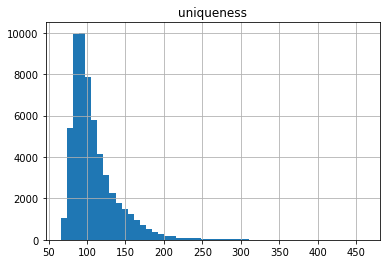

In [15]:
unique_df.hist(bins=50)
plt.show()

In [16]:
# Add the column back to df_knn
df_knn["uniqueness"] = unique_df["uniqueness"]

# And view the new dataframe
df_knn.head()

,duration,pass_length,pass_angle,location_origin_x,location_origin_y,location_dest_x,location_dest_y,uniqueness
id,,,,,,,,
f8fc67b7-55f0-456e-be81-745c9be6ca4f,1.400,26.019224,1.532354,34.0,36.0,35.0,62.0,92.373710
e8f1fe86-a2c2-41ea-85df-376cfcc667ee,0.840,11.180340,1.390943,74.0,14.0,76.0,25.0,81.967820
305e9fc5-c031-47a8-99d2-632181f65a45,1.600,35.014282,1.599360,86.0,33.0,85.0,68.0,128.495855
33d55bfe-a135-4767-9f6f-f274eb0d76eb,1.573,12.000000,3.141593,45.0,18.0,33.0,18.0,117.796375
f1de6609-1f2a-44f2-8de4-eef63203e783,1.187,7.211102,0.588003,34.0,14.0,40.0,18.0,98.462979


# Plotting Unique Passes

Attempt to visually assess if the model grouped similar passes

In [17]:
def get_similar_passes(p, df, model, cutoff=None, n_top=None, plotting=True):
    dist, passes = model.kneighbors(p, n_neighbors=len(df), return_distance=True)
    
    if n_top is not None:
        val = n_top
    else:    
        val = np.searchsorted(dist[0], cutoff)

    if plotting:
        return list(zip(passes[0][1:val], dist[0][1:val]))
    else:
        return passes[0][1:val]
    
def plot_similar_passes(sim_passes, rand_pass=None):
    plot = plotpitch_bokeh(display=False)

    # Pass map
    for sim_pid, value in sim_passes:
        line = df_knn.iloc[sim_pid]
        x,y,dx,dy,c = getArrow(
            (line["location_origin_x"], line["location_origin_y"]),
            (line["location_dest_x"], line["location_dest_y"]),
            color='blue', qualifier='blue', viz="bokeh")
        plot.add_layout(Arrow(end=OpenHead(size=10, line_color=c), 
                              line_color=c,
                              x_start=x, y_start=y, x_end=dx, y_end=dy))

    if rand_pass is not None:
        line = df_knn.iloc[rand_pass]
        x,y,dx,dy,c = getArrow(
            (line["location_origin_x"], line["location_origin_y"]),
            (line["location_dest_x"], line["location_dest_y"]),
            color='red', viz="bokeh")
        plot.add_layout(Arrow(end=OpenHead(size=20, line_color=c), 
                              line_color=c, line_width=4,
                              x_start=x, y_start=y, x_end=dx, y_end=dy))


    show(plot)


In [18]:
rand_pass = 12345

p = df_knn_norm[rand_pass].reshape(1,-1)
pid =  df_knn.iloc[rand_pass].name

sim_passes = get_similar_passes(p, df_knn_norm, nn_model, cutoff=.1, plotting=True)

plot_similar_passes(sim_passes, rand_pass=rand_pass)

In [19]:
rand_pass = 15

p = df_knn_norm[rand_pass].reshape(1,-1)
pid =  df_knn.iloc[rand_pass].name

sim_passes = get_similar_passes(p, df_knn_norm, nn_model, n_top=50)

plot_similar_passes(sim_passes, rand_pass=rand_pass)

# Most Unique Passers and Passes

In [20]:
df_unique_pass = pd.merge(df_passes, df_knn[["uniqueness"]], left_on="id", right_on=df_knn.index)

In [21]:
top_20_unique = df_unique_pass.loc[:, ("player_name", "position_name", "location_origin_x", "location_origin_y", "location_dest_x", "location_dest_y", "uniqueness")].sort_values("uniqueness", ascending=False).head(20)

In [22]:
plot_similar_passes(list(zip(top_20_unique.index, top_20_unique["uniqueness"])))

In [23]:
top_passers = df_unique_pass.groupby(["team_name", "player_name"], as_index=False)\
    .agg({"uniqueness": ["count", "sum"]})
top_passers.columns = ["team_name", "player_name", "passes", "uniqueness"]
top_passers["uniqueness_per_pass"] = top_passers["uniqueness"] / top_passers["passes"]

In [24]:
top_passers.loc[top_passers["passes"] > 300, :].sort_values("uniqueness_per_pass", ascending=False).head(10)

,team_name,player_name,passes,uniqueness,uniqueness_per_pass
122,Croatia,Ivan Rakitić,401,45465.179187,113.379499
134,Croatia,Šime Vrsaljko,320,35838.830303,111.996345
117,Croatia,Dejan Lovren,360,40256.630658,111.823974
548,Switzerland,Granit Xhaka,336,37214.853710,110.758493
126,Croatia,Luka Modrić,467,50911.496036,109.018193
185,England,Kyle Walker,378,41131.695078,108.814008
41,Belgium,Kevin De Bruyne,315,34231.252451,108.670643
40,Belgium,Jan Vertonghen,315,33874.551661,107.538259
118,Croatia,Domagoj Vida,313,33583.968025,107.297022
127,Croatia,Marcelo Brozović,367,38922.291629,106.055291


# Unique Passes In Final Third

In [25]:
# Attacking half or balls starting deep in opponent half that travel backwards
filt_attack = (
    ((df_unique_pass["location_origin_x"] > 60) & (df_unique_pass["location_dest_x"] > df_unique_pass["location_origin_x"]))
    | ((df_unique_pass["location_origin_x"] > 80) & (df_unique_pass["location_dest_x"] > 60)))
# Remove top .25% of values for being TOO random
filt_top = (
    df_unique_pass["uniqueness"] < df_unique_pass["uniqueness"].quantile(.975))

In [26]:
attacking = df_unique_pass.loc[(filt_attack & filt_top), :].sort_values("uniqueness", ascending=False)

In [27]:
# Most unique passes
attacking_top_10 = attacking.dropna(axis=1).head(10)

In [28]:
plot_similar_passes(list(zip(attacking_top_10.index, attacking_top_10["uniqueness"])))

In [29]:
# Most unique Passes in Final Third

top_passers_attacking = attacking.groupby(["team_name", "player_name"], as_index=False)\
    .agg({"uniqueness": ["count", "sum"]})
top_passers_attacking.columns = ["team_name", "player_name", "passes", "uniqueness"]
top_passers_attacking["uniqueness_per_pass"] = top_passers_attacking["uniqueness"] / top_passers_attacking["passes"]

In [30]:
top_passers_attacking.loc[top_passers_attacking["passes"] > 100, :].sort_values("uniqueness_per_pass", ascending=False).head(20)

,team_name,player_name,passes,uniqueness,uniqueness_per_pass
161,England,Harry Kane,110,12742.281272,115.838921
111,Croatia,Ivan Rakitić,135,14978.112087,110.948978
110,Croatia,Ivan Perišić,107,11801.626784,110.295577
167,England,Kieran Trippier,141,15402.475599,109.237416
514,Switzerland,Xherdan Shaqiri,112,12169.536653,108.656577
45,Belgium,Thomas Meunier,109,11776.088061,108.037505
174,France,Antoine Griezmann,132,14185.842624,107.468505
410,Saudi Arabia,Salman Mohammed Al Faraj,104,11153.617514,107.246322
38,Belgium,Kevin De Bruyne,166,17672.894778,106.463222
114,Croatia,Luka Modrić,216,22909.714385,106.063493


# Rakitic Plot

In [31]:
rakitic = df_unique_pass.loc[df_unique_pass["player_name"] == "Ivan Rakitić", :]
plot_similar_passes(list(zip(rakitic.index, rakitic["uniqueness"])))

In [32]:
rakitic_attacking = attacking.loc[attacking["player_name"] == "Ivan Rakitić", :]
plot_similar_passes(list(zip(rakitic_attacking.index, rakitic_attacking["uniqueness"])))